In [3]:
#import packages
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import math,random
import subprocess

#machine learning
from sklearn import datasets
from sklearn.svm import OneClassSVM,SVC
from sklearn.metrics import roc_curve,auc

# Packages for visuals
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns; sns.set(font_scale=1.2)

# Allows charts to appear in the notebook
%matplotlib inline


Importing data from CSV file:

In [4]:
keystroke = pd.read_csv('downloads/keystroke.csv')

keystroke.head()


,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


In [14]:

subjects = keystroke["subject"].unique()

In [6]:

def evaluateEER(user_scores, imposter_scores):
    labels = [0]*len(user_scores) + [1]*len(imposter_scores)
    fpr, tpr, thresholds = roc_curve(labels, user_scores + imposter_scores)
    missrates = 1 - tpr
    farates = fpr
    dists = missrates - farates
    idx1 = np.argmin(dists[dists >= 0])
    idx2 = np.argmax(dists[dists < 0])
    x = [missrates[idx1], farates[idx1]]
    y = [missrates[idx2], farates[idx2]]
    a = ( x[0] - x[1] ) / ( y[1] - x[1] - y[0] + x[0] )
    eer = x[0] + a * ( y[0] - x[0] )
    return eer

Training the model:


In [7]:
#def evaluate():
eers = []
    
for subject in subjects:
            
        user_scores = []
        imposter_scores = []
    
        # Consider current subject as genuine and rest as imposters
        genuine_user_data = keystroke.loc[keystroke.subject == subject, "H.period":"H.Return"]
        imposter_data = keystroke.loc[keystroke.subject != subject, :]
    
        # genuine user's first 200 time vectors for training
        train = genuine_user_data[:200]
        train = train.values
        train = np.array(train)
        
        #print type(labels[0])
        test_genuine = genuine_user_data[200:]
        test_genuine = test_genuine.values
        test_genuine = np.array(test_genuine)
        test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
        test_imposter = test_imposter.values
        test_imposter = np.array(test_imposter)
        clf = OneClassSVM(kernel='rbf',gamma=26)
        clf.fit(train)
        #print len(test_genuine)
        #print len(test_imposter)
        user_scores = -clf.decision_function(test_genuine)
        imposter_scores = -clf.decision_function(test_imposter)
        #user_scores = clf.predict(test_genuine)
        #imposter_scores = clf.predict(test_imposter)
        user_scores = list(user_scores)
        imposter_scores = list(imposter_scores)
        #eers.append(evaluateEER(user_scores, imposter_scores))
        labels = [0]*len(user_scores) + [1]*len(imposter_scores)
        fpr, tpr, thresholds = roc_curve(labels, user_scores + imposter_scores)
        missrates = 1 - tpr
        farates = fpr
        dists = missrates - farates
        idx1 = np.argmin(dists[dists >= 0])
        idx2 = np.argmax(dists[dists < 0])
        x = [missrates[idx1], farates[idx1]]
        y = [missrates[idx2], farates[idx2]]
        a = ( x[0] - x[1] ) / ( y[1] - x[1] - y[0] + x[0] )
        #eer = x[0] + a * ( y[0] - x[0] )
        eers.append(x[0] + a * ( y[0] - x[0] ))
        MeanEER= np.mean(eers)
        
    
    
    
    #print (eers)   
    #return np.mean(eers)
        

##  EER  

In [9]:
MeanEER

0.12065079948315142

### Plotting the User vs Period Hold time, User vs Key down-down period time, User Vs Key up down period time.Graph depicts the outliers for each of the cases.

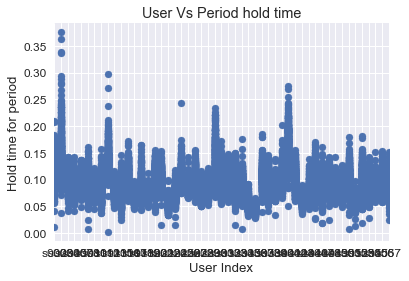

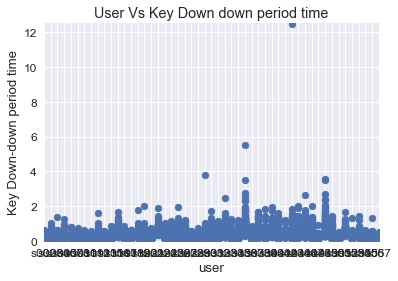

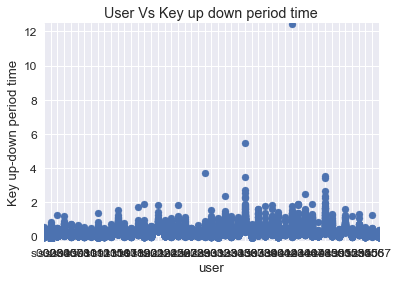

In [15]:

x = keystroke.loc[:, 'subject']
y = keystroke.loc[:, 'H.period']
plt.scatter(x, y)
plt.autoscale(tight=True)
plt.title('User Vs Period hold time')
plt.ylabel('Hold time for period')
plt.xlabel('User Index')
plt.show()
x = keystroke.loc[:, 'subject']
y = keystroke.loc[:, 'DD.period.t']
plt.scatter(x, y)
plt.autoscale(tight=True)
plt.title('User Vs Key Down down period time')
plt.ylabel('Key Down-down period time')
plt.xlabel('user')
plt.show()
x = keystroke.loc[:, 'subject']
y = keystroke.loc[:, 'UD.period.t']
plt.scatter(x, y)
plt.autoscale(tight=True)
plt.title('User Vs Key up down period time')
plt.ylabel('Key up-down period time')
plt.xlabel('user')
plt.show()



### Scatter plot shows distrubution of genuine user and imposter keystroke data

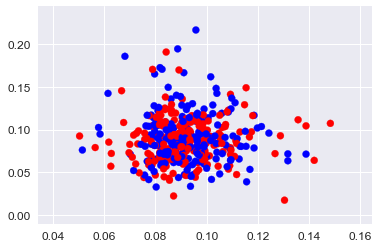

In [29]:
genuine_user_data = keystroke.loc[keystroke.subject == 's005',"H.period" and "H.Return"]
imposter_data = keystroke.loc[keystroke.subject != 's005', "H.period" and "H.Return"]
imposter_train = imposter_data.sample (n=400)

plt.scatter (genuine_user_data, imposter_train,c=['blue','red'])

plt.show()



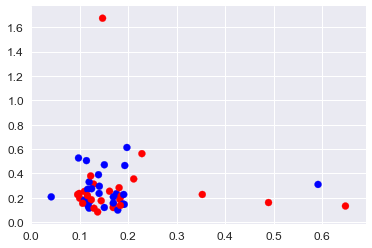

In [30]:
genuine_user_data = keystroke.loc[keystroke.subject == 's003',"H.period" and "DD.period.t"]
G_data= genuine_user_data.sample(n=50)
imposter_data = keystroke.loc[keystroke.subject != 's003', "H.period" and "DD.period.t"]
imposter_train = imposter_data.sample (n=50)

plt.scatter (G_data, imposter_train,c=['blue','red'])

plt.show()

## Plotting ROC curve:

ROC curve is a two-dimensional measure of classification performance. It can be understood as a plot of the probability of classifying correctly the positive examples against the rate of incorrectly classifying true negative examples. In this sense, one can interpret this curve as a comparison of the classifier across the entire range of class distributions.

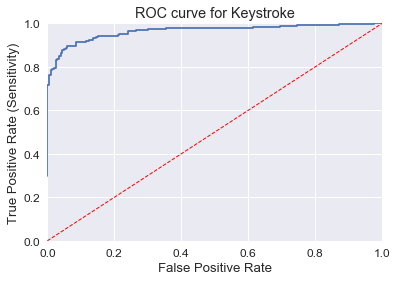

In [95]:
plt.figure()
lw = 1
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Keystroke')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
roc_auc= auc(fpr,tpr)


## Computing Area Under the curve (AUC)

In [96]:
print(roc_auc)

0.96476


## Area under the curve = 0.96

## EER from ROC Curve

In [29]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d

eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)



In [30]:
print(eer)

0.08799999999996862


### Confusion matrix

In [31]:
import itertools
import numpy as np
import csv,sys
import math,random
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


data = pd.read_csv('downloads/keystroke.csv')


#Get the Training Data
# Take Genuine data for Subject S005 and randomn 200 Imposter data for training
class_names = ['s005','imposter']
class_names = np.array(class_names)

genuine_user_data = data.loc[data.subject == 's005', "H.period" : "H.Return"]
imposter_data = data.loc[data.subject != 's005', "H.period" : "H.Return"]
#ygen_user = data.loc[data.subject == 's005',"subject"]
#imposter_train = data.loc[data.subject != 's002', :]

imp_train = imposter_data.sample(n=100)
train = genuine_user_data[:300]
train_gen_imp = pd.concat([train, imp_train], axis=0)
#train_tmp = train_gen_imp.values
X_train = np.array(train_gen_imp)

ytrain = [0] * 300 + [1] * 100

y_train= np.array(ytrain)

# For the Training Data

test_genuine = genuine_user_data[200:400]

imp_test = imposter_data.sample(n=200)
test_gen_tmp = pd.concat([test_genuine, imp_test], axis=0)
test_gen_imp = test_gen_tmp.values
X_test = np.array(test_gen_imp)
ytest = [0] * 200 + [1] * 200
y_test = np.array(ytest)
#ytrain = [1]*train.count()
#labels = np.ones(len(train),dtype = np.float64)
#print type(labels[0])
#test_genuine = genuine_user_data[200:400]
#y_test = ytrain
#test_genuine = test_genuine.values
#test_genuine = np.array(test_genuine)

#X_test = test_genuine

#test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
#test_imposter = test_imposter.values
#test_imposter = np.array(test_imposter)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
#classifier = svm.SVC(kernel='linear', C=0.01)








Confusion matrix, without normalization
[[197   3]
 [ 61 139]]
Normalized confusion matrix
[[ 0.98  0.01]
 [ 0.3   0.69]]


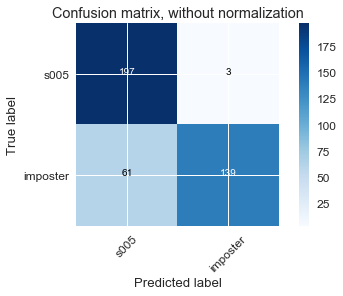

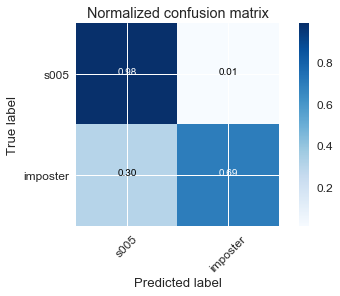

In [17]:
classifier = svm.SVC(kernel='rbf', C=26)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
   """
   This function prints and plots the confusion matrix.
   Normalization can be applied by setting `normalize=True`.
   """
   if normalize:
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       print("Normalized confusion matrix")
   else:
       print('Confusion matrix, without normalization')

   print(cm)

   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)

   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                     title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                     title='Normalized confusion matrix')

plt.show()



### Determining accuracy

In [32]:
from sklearn.metrics import accuracy_score ,precision_score
accuracy_score(y_test, y_pred)




0.83999999999999997

### Precision:

In [33]:
precision_score(y_test, y_pred,average = 'weighted')

0.87121956545474399

### Cross-validation 

In [36]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='rbf', C=100)
scores = cross_val_score(clf, X_test, y_test, cv=10)


In [37]:
#The mean score:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.92 (+/- 0.08)


# Still working..

In [626]:
#keystroke = datasets.load_keystroke()
#keystroke = pd.read_csv('downloads/keystroke.csv')
#iris = datasets.load_iris()
#X = keystroke.loc[keystroke.subject == subject, "H.period":"H.Return"]
#y = keystroke['subject']
X = X_train
y = y_train
X_plot = X_test

# Plot resulting Support Vector boundaries with original data
# Create fake input data for prediction that we will use for plotting
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = (x_max / x_min)/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
 np.arange(y_min, y_max, h))
X_plot = np.c_[xx.ravel(), yy.ravel()]

# Create the SVC model object
C = 1.0 # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C, decision_function_shape='ovr').fit(X, y)
Z = svc.predict(X_plot)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.contourf(xx, yy, Z, cmap=plt.cm.tab10, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1)
plt.xlabel('H.period')
plt.ylabel('DD.period.t')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with linear kernel')

# Create the SVC model object
C = 1.0 # SVM regularization parameter
svc = svm.SVC(kernel='rbf', C=1, decision_function_shape='ovr').fit(X, y)

Z = svc.predict(X_plot)
Z = Z.reshape(xx.shape)

plt.subplot(122)
plt.contourf(xx, yy, Z, cmap=plt.cm.tab10, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1)
plt.xlabel('H.period')
plt.ylabel('DD.period.t')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with RBF kernel')

plt.show()
print(subject.groupby('subject').size())

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [245]:
from IPython.display import display, HTML
df = pd.DataFrame({'Hit rate': tpr, 'FPR': fpr,'Threshold':thresholds,'FNR':missrates,'TNR':tnr})
pd.set_option('display.max_rows', 100)
#display(df)


df['Threshold'].describe()


count    99.000000
mean      1.757665
std       0.740579
min      -0.834746
25%       1.381297
50%       2.057641
75%       2.382413
max       2.466774
Name: Threshold, dtype: float64